<a href="https://colab.research.google.com/github/bzeng18/AIPI531/blob/main/dqn_sb3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DQN and Double DQN with Stable-Baselines3

Stable-Baselines3: https://github.com/DLR-RM/stable-baselines3

Documentation: https://stable-baselines.readthedocs.io/en/master/

RL Baselines3 zoo: https://github.com/DLR-RM/rl-baselines3-zoo

Double Q-Learning: https://paperswithcode.com/method/double-q-learning


[RL Baselines3 Zoo](https://github.com/DLR-RM/rl-baselines3-zoo) is a training framework for Reinforcement Learning (RL), using Stable Baselines3.

It provides scripts for training, evaluating agents, tuning hyperparameters, plotting results and recording videos.

## Introduction

In this notebook, we will study DQN using Stable-Baselines3 and then see how to reduce value overestimation with double DQN.

## Installation

We will install master version of SB3.

In [21]:
# for autoformatting
# %load_ext jupyter_black

In [22]:
!apt-get install ffmpeg freeglut3-dev xvfb  # For visualization

!pip install "stable-baselines3[extra]>=2.0.0a4"

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
freeglut3-dev is already the newest version (2.8.1-6).
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
xvfb is already the newest version (2:21.1.4-2ubuntu1.7~22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 18 not upgraded.


Import DQN and evaluation helper

In [23]:
import gymnasium as gym
import numpy as np
import torch as th
import matplotlib.pyplot as plt

from stable_baselines3 import DQN
from stable_baselines3.common.evaluation import evaluate_policy

## The Mountain Car Problem

In this environment, the agent must drive an underpowered car up a steep mountain road. For any given state the agent may choose to accelerate to the left, right or cease any acceleration.

Source: https://github.com/Farama-Foundation/Gymnasium/blob/main/gymnasium/envs/classic_control/mountain_car.py

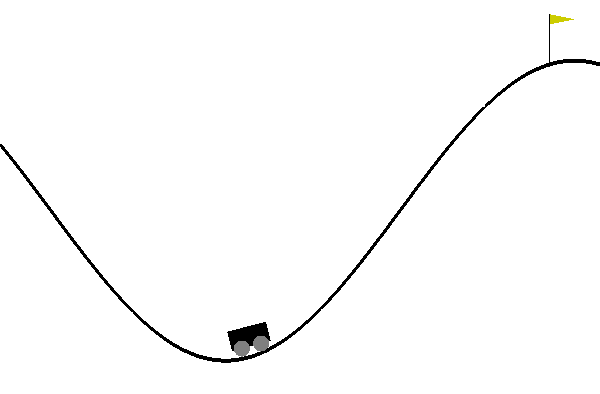


    Observation:
        Type: Box(2)
        Num    Observation               Min            Max
        0      Car Position              -1.2           0.6
        1      Car Velocity              -0.07          0.07
    Actions:
        Type: Discrete(3)
        Num    Action
        0      Accelerate to the Left
        1      Don't accelerate
        2      Accelerate to the Right
        Note: This does not affect the amount of velocity affected by the
        gravitational pull acting on the car.
    Reward:
         Reward of 0 is awarded if the agent reached the flag (position = 0.5)
         on top of the mountain.
         Reward of -1 is awarded if the position of the agent is less than 0.5.
    Starting State:
         The position of the car is assigned a uniform random value in
         [-0.6 , -0.4].
         The starting velocity of the car is always assigned to 0.
    Episode Termination:
         The car position is more than 0.5
         Episode length is greater than 200



Create the environment

In [24]:
env = gym.make("MountainCar-v0", render_mode="rgb_array")

Create the model with tuned hyperparameters from the RL Zoo

```yaml
MountainCar-v0:
  n_timesteps: !!float 1.2e5
  policy: 'MlpPolicy'
  learning_rate: !!float 4e-3
  batch_size: 128
  buffer_size: 10000
  learning_starts: 1000
  gamma: 0.98
  target_update_interval: 600
  train_freq: 16
  gradient_steps: 8
  exploration_fraction: 0.2
  exploration_final_eps: 0.07
  policy_kwargs: "dict(net_arch=[256, 256])"
```

In [25]:
tensorboard_log = "data/tb/"

In [26]:
dqn_model = DQN(
    "MlpPolicy",
    env,
    verbose=1,
    train_freq=16,
    gradient_steps=8,
    gamma=0.99,
    exploration_fraction=0.2,
    exploration_final_eps=0.07,
    target_update_interval=600,
    learning_starts=1000,
    buffer_size=10000,
    batch_size=128,
    learning_rate=4e-3,
    policy_kwargs=dict(net_arch=[256, 256]),
    tensorboard_log=tensorboard_log,
    seed=2,
)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


Evaluate the agent before training

In [27]:
mean_reward, std_reward = evaluate_policy(
    dqn_model,
    dqn_model.get_env(),
    deterministic=True,
    n_eval_episodes=20,
)

print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

mean_reward:-200.00 +/- 0.00


In [28]:
# Optional: Monitor training in tensorboard
# %load_ext tensorboard
# %tensorboard --logdir $tensorboard_log

We will first train the agent until convergence and then analyse the learned q-value function.

In [29]:
dqn_model.learn(int(1.2e5), log_interval=10)

Logging to data/tb/DQN_2
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | -200     |
|    exploration_rate | 0.922    |
| time/               |          |
|    episodes         | 10       |
|    fps              | 680      |
|    time_elapsed     | 2        |
|    total_timesteps  | 2000     |
| train/              |          |
|    learning_rate    | 0.004    |
|    loss             | 1.97e-05 |
|    n_updates        | 496      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | -200     |
|    exploration_rate | 0.845    |
| time/               |          |
|    episodes         | 20       |
|    fps              | 285      |
|    time_elapsed     | 13       |
|    total_timesteps  | 4000     |
| train/              |          |
|    learning_rate    | 0.004    |
|    loss             | 9.68e-

Evaluate after training, the mean episodic reward should have improved.

In [30]:
mean_reward, std_reward = evaluate_policy(dqn_model, dqn_model.get_env(), deterministic=True, n_eval_episodes=20)

print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

mean_reward:-103.25 +/- 17.24


### Prepare video recording

In [41]:
# Set up fake display; otherwise rendering will fail
import os
os.system("Xvfb :1 -screen 0 1024x768x24 &")
os.environ['DISPLAY'] = ':1'

In [42]:
import base64
from pathlib import Path

from IPython import display as ipythondisplay


def show_videos(video_path="", prefix=""):
    """
    Taken from https://github.com/eleurent/highway-env

    :param video_path: (str) Path to the folder containing videos
    :param prefix: (str) Filter the video, showing only the only starting with this prefix
    """
    html = []
    for mp4 in Path(video_path).glob("{}*.mp4".format(prefix)):
        video_b64 = base64.b64encode(mp4.read_bytes())
        html.append(
            """<video alt="{}" autoplay
                    loop controls style="height: 400px;">
                    <source src="data:video/mp4;base64,{}" type="video/mp4" />
                </video>""".format(
                mp4, video_b64.decode("ascii")
            )
        )
    ipythondisplay.display(ipythondisplay.HTML(data="<br>".join(html)))

We will record a video using the [VecVideoRecorder](https://stable-baselines.readthedocs.io/en/master/guide/vec_envs.html#vecvideorecorder) wrapper, you will learn about those wrapper in the next notebook.

In [43]:
from stable_baselines3.common.vec_env import VecVideoRecorder, DummyVecEnv


def record_video(
    env_id,
    model,
    video_length=500,
    prefix="",
    video_folder="videos/",
):
    """
    :param env_id: (str)
    :param model: (RL model)
    :param video_length: (int)
    :param prefix: (str)
    :param video_folder: (str)
    """
    eval_env = DummyVecEnv([lambda: gym.make(env_id, render_mode="rgb_array")])
    # Start the video at step=0 and record 500 steps
    eval_env = VecVideoRecorder(
        eval_env,
        video_folder=video_folder,
        record_video_trigger=lambda step: step == 0,
        video_length=video_length,
        name_prefix=prefix,
    )

    obs = eval_env.reset()
    for _ in range(video_length):
        action, _ = model.predict(obs, deterministic=False)
        obs, _, _, _ = eval_env.step(action)

    # Close the video recorder
    eval_env.close()

## Visualize trained agent

In [34]:
record_video("MountainCar-v0", dqn_model, video_length=500, prefix="dqn-mountaincar")

Saving video to /content/videos/dqn-mountaincar-step-0-to-step-500.mp4
Moviepy - Building video /content/videos/dqn-mountaincar-step-0-to-step-500.mp4.
Moviepy - Writing video /content/videos/dqn-mountaincar-step-0-to-step-500.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/dqn-mountaincar-step-0-to-step-500.mp4


In [35]:
show_videos("videos", prefix="dqn")

## Visualize Q-values

### Exercise (5 minutes): Retrieve q-values

The function will be used to retrieve the learned q-values for a given state (`observation` in the code).

The q-network from SB3 DQN can be accessed via `model.q_net` and is a PyTorch module (you can therefore call `.forward()` on it).

You need to convert the observation to a PyTorch tensor and then convert the resulting q-values to numpy array.

Note: It is recommended to use `with th.no_grad():` context to save computation and memory

In [74]:
def get_q_values(model: DQN, obs: np.ndarray) -> np.ndarray:
    """
    Retrieve Q-values for a given observation.

    :param model: a DQN model
    :param obs: a single observation
    :return: the associated q-values for the given observation
    """
    assert model.get_env().observation_space.contains(obs), f"Invalid observation of shape {obs.shape}: {obs}"
    ### YOUR CODE HERE
    # Retrieve q-values for the given observation and convert them to numpy
    obs_tensor = th.tensor(obs, dtype=th.float32).unsqueeze(0)
    with th.no_grad():
        q_values_tensor = model.q_net.forward(obs_tensor)
    q_values = q_values_tensor.squeeze(0).numpy()

    ### END OF YOUR CODE
    assert isinstance(q_values, np.ndarray), "The returned q_values is not a numpy array"
    assert q_values.shape == (3,), f"Wrong shape: (3,) was expected but got {q_values.shape}"

    return q_values

### Q-values for the initial state

Let's reset the environment to start a new episode:

In [75]:
obs, _ = env.reset()

we plot the rendered environment to visualize it

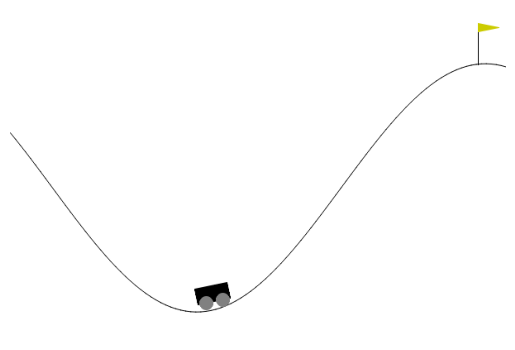

In [76]:
plt.axis('off')
plt.imshow(env.render())

### Exercise (5 minutes): predict taken action according to q-values

Using the `get_q_values()` function, retrieve the q-values for the initial observation, print them for each action ("left", "nothing", "right") and print the action that the greedy (deterministic) policy would follow (i.e., the action with the highest q-value for that state).

In [77]:
action_str = ["Left", "Nothing", "Right"]  # action=0 -> go left, action=1 -> do nothing, action=2 -> go right

In [78]:
### YOUR CODE HERE
# Retrieve q-values for the initial state
# You should use `get_q_values()`
q_values = get_q_values(dqn_model, obs)
q_value_left, q_value_nothing, q_value_right = q_values

### END OF YOUR CODE

print(f"Q-value of the initial state left={q_value_left:.2f} nothing={q_value_nothing:.2f} right={q_value_right:.2f}")

### YOUR CODE HERE
# Compute the action taken in the initilal state according to q-values
# when following a greedy strategy
action = np.argmax(q_values)

## END of your code here

print(f"Action taken by the greedy policy in the initial state: {action_str[action]}")

Q-value of the initial state left=-61.15 nothing=-61.55 right=-61.52
Action taken by the greedy policy in the initial state: Left


The q-value of the initial state corresponds to how much (discounted) reward the agent expects to get in this episode.

We will compare the estimated q-value to the discounted return of the episode.

In [79]:
initial_q_value = q_values.max()

## Step until the end of the episode



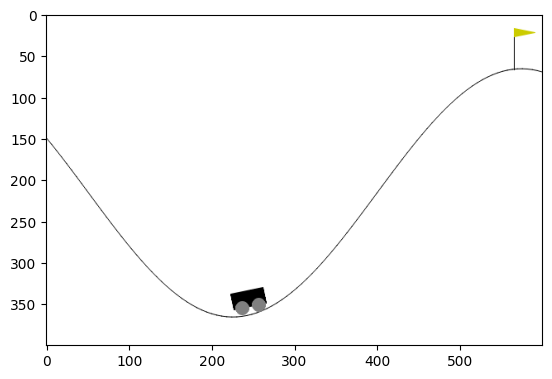

Q-value of the current state left=-61.15 nothing=-61.55 right=-61.52
Action: Left


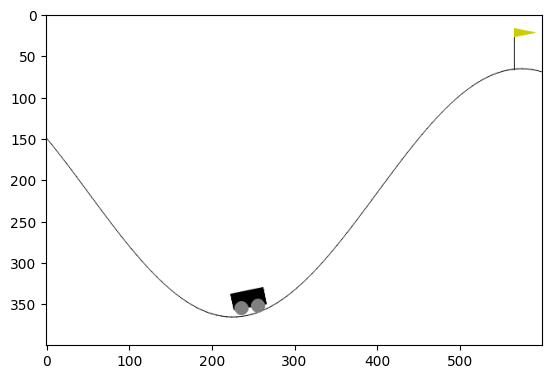

Q-value of the current state left=-59.70 nothing=-60.20 right=-60.23
Action: Left


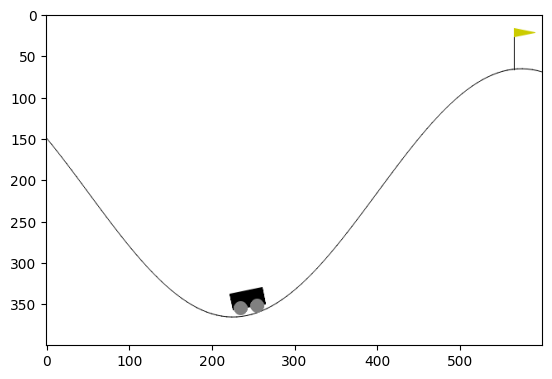

Q-value of the current state left=-59.06 nothing=-59.63 right=-59.73
Action: Left


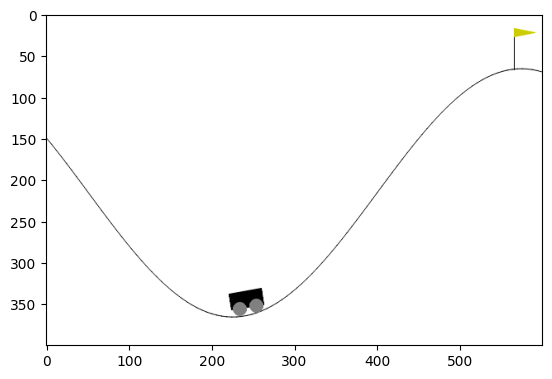

Q-value of the current state left=-58.62 nothing=-59.24 right=-59.44
Action: Left


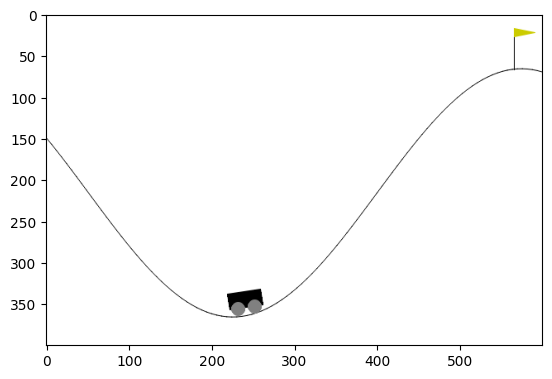

Q-value of the current state left=-57.61 nothing=-58.27 right=-58.55
Action: Left


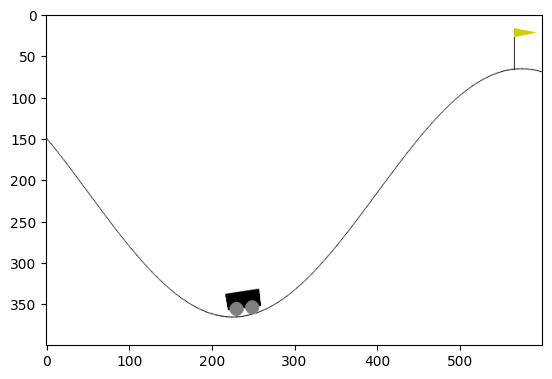

Q-value of the current state left=-56.71 nothing=-57.42 right=-57.78
Action: Left


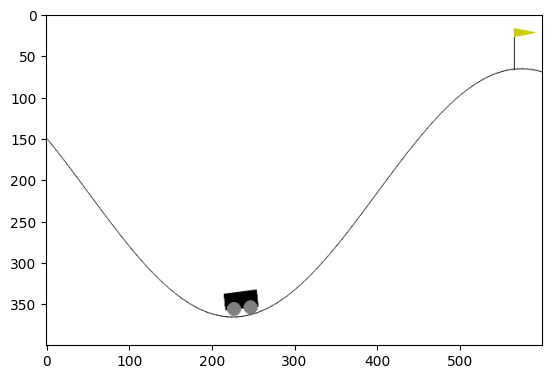

Q-value of the current state left=-55.90 nothing=-56.68 right=-57.12
Action: Left


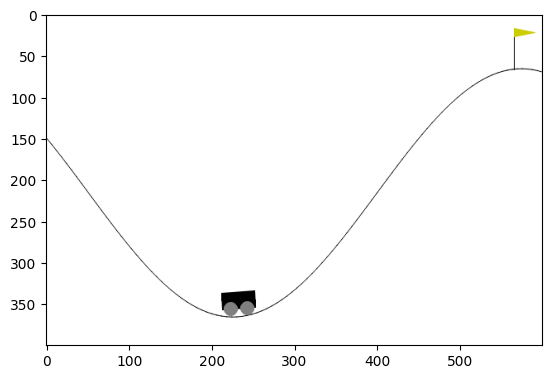

Q-value of the current state left=-55.21 nothing=-56.06 right=-56.58
Action: Left


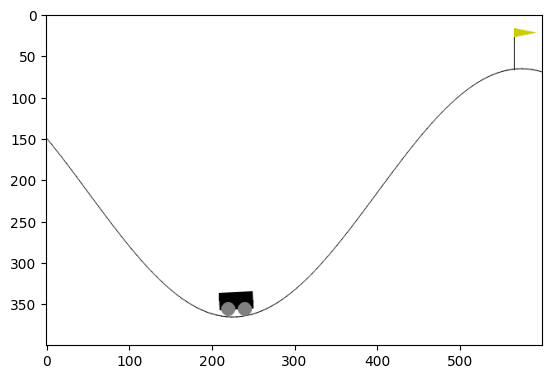

Q-value of the current state left=-54.63 nothing=-55.57 right=-56.17
Action: Left


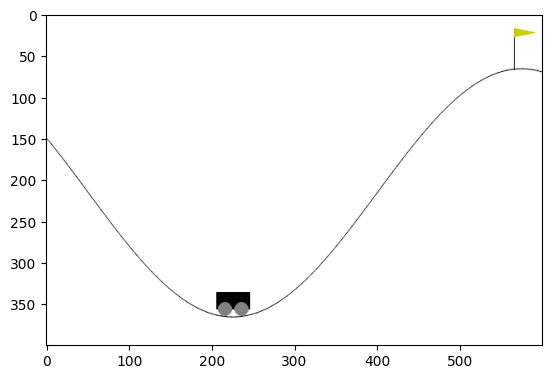

Q-value of the current state left=-54.10 nothing=-55.11 right=-55.78
Action: Left


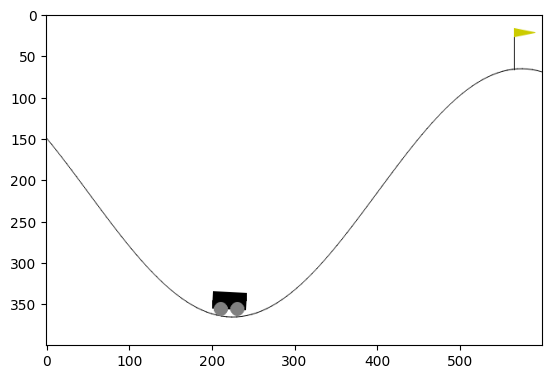

Q-value of the current state left=-53.60 nothing=-54.67 right=-55.40
Action: Left


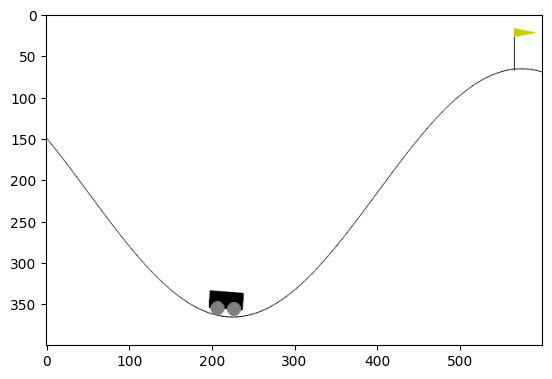

Q-value of the current state left=-53.23 nothing=-54.36 right=-55.13
Action: Left


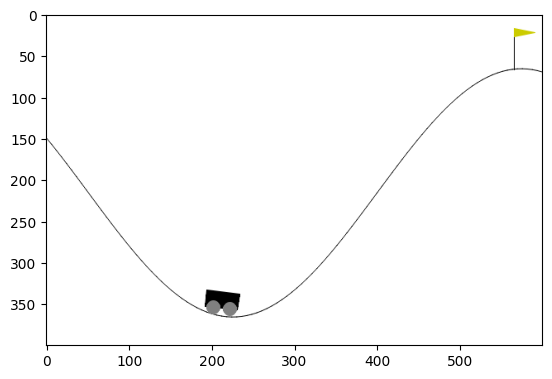

Q-value of the current state left=-52.82 nothing=-54.01 right=-54.82
Action: Left


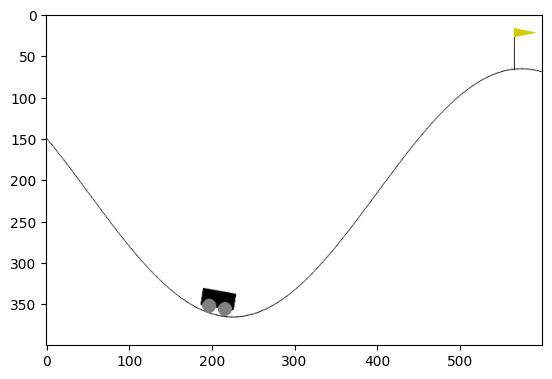

Q-value of the current state left=-52.48 nothing=-53.73 right=-54.57
Action: Left


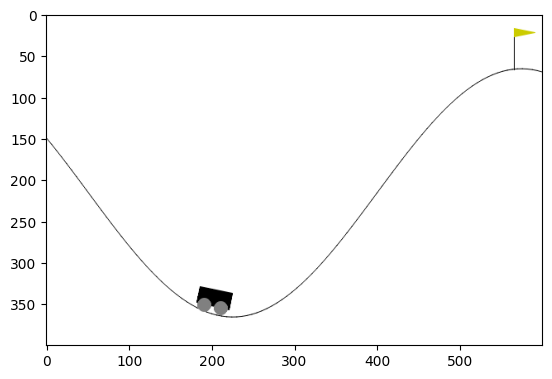

Q-value of the current state left=-52.19 nothing=-53.49 right=-54.35
Action: Left


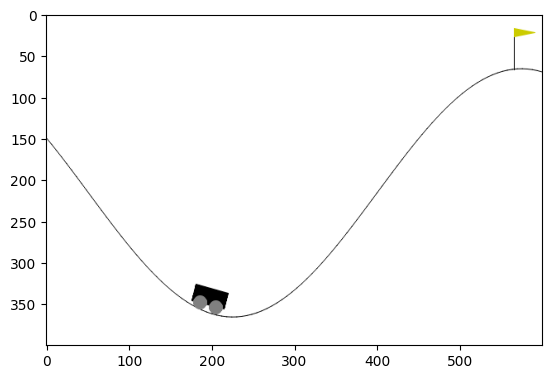

Q-value of the current state left=-52.13 nothing=-53.39 right=-54.22
Action: Left


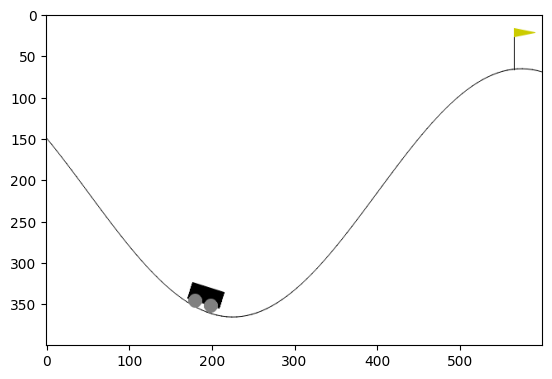

Q-value of the current state left=-51.66 nothing=-52.84 right=-53.61
Action: Left


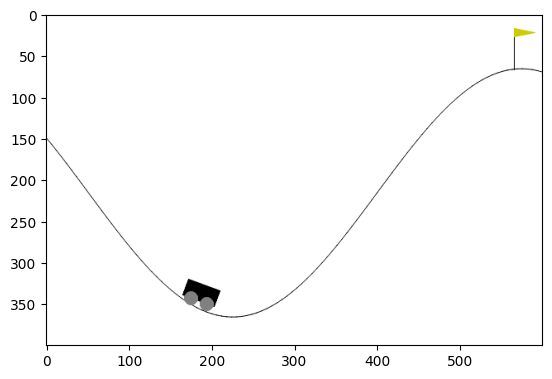

Q-value of the current state left=-51.22 nothing=-52.31 right=-53.01
Action: Left


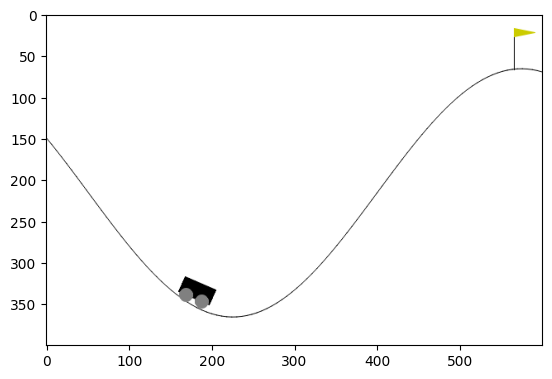

Q-value of the current state left=-51.43 nothing=-52.47 right=-53.13
Action: Left


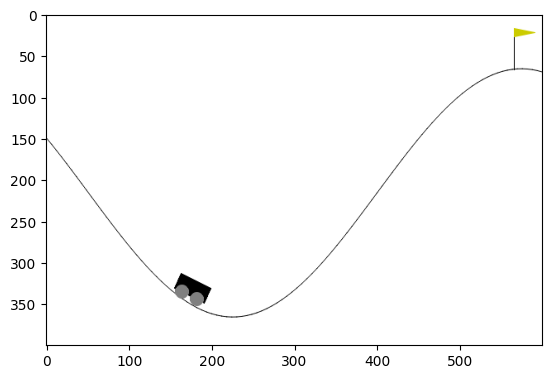

Q-value of the current state left=-51.32 nothing=-52.37 right=-53.08
Action: Left


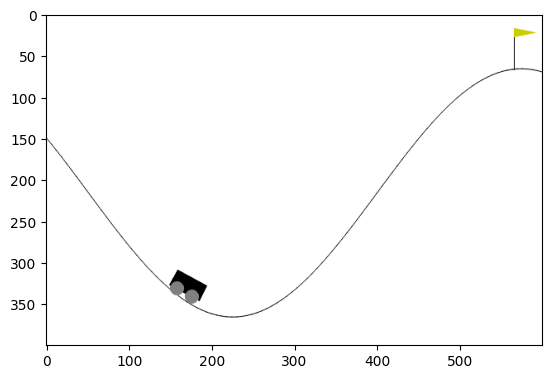

Q-value of the current state left=-50.84 nothing=-51.85 right=-52.53
Action: Left


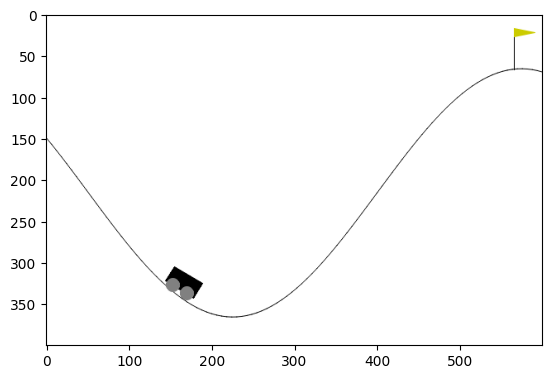

Q-value of the current state left=-50.53 nothing=-51.48 right=-52.14
Action: Left


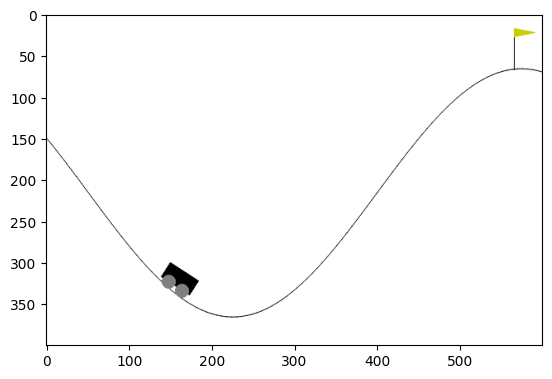

Q-value of the current state left=-50.33 nothing=-51.23 right=-51.85
Action: Left


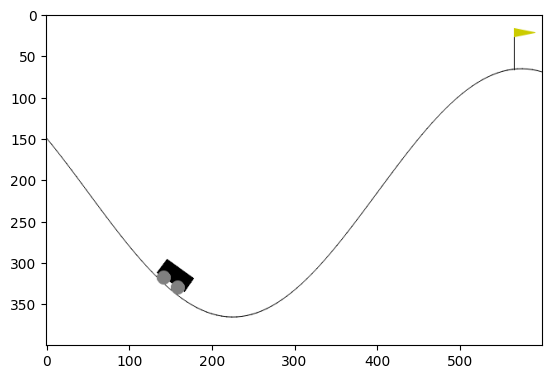

Q-value of the current state left=-50.25 nothing=-51.08 right=-51.67
Action: Left


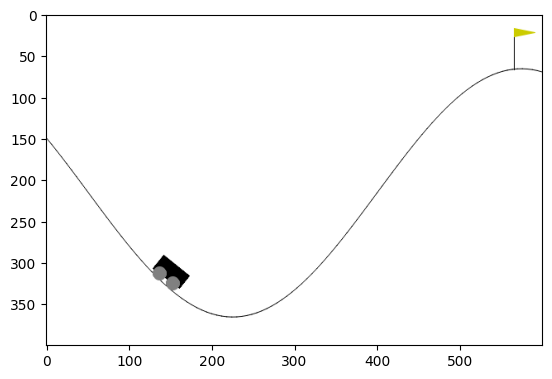

Q-value of the current state left=-50.28 nothing=-51.05 right=-51.59
Action: Left


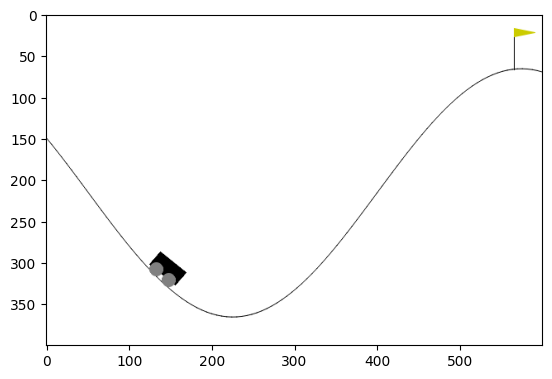

Q-value of the current state left=-50.42 nothing=-51.13 right=-51.63
Action: Left


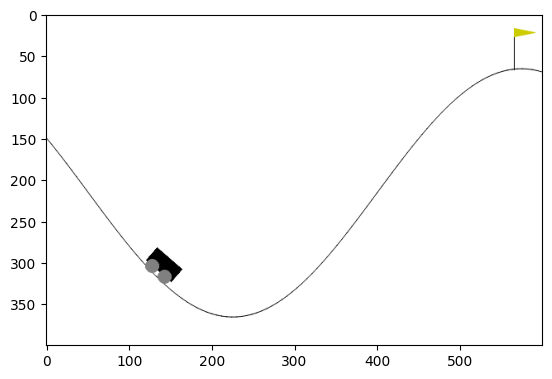

Q-value of the current state left=-50.55 nothing=-51.20 right=-51.65
Action: Left


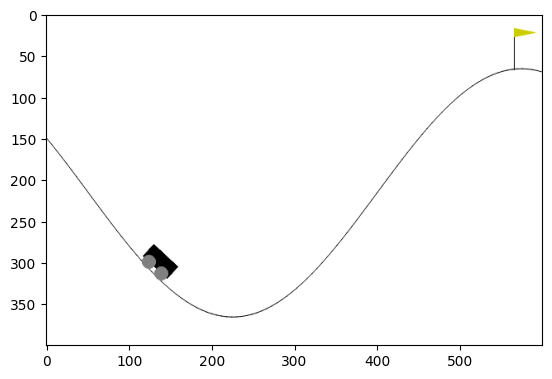

Q-value of the current state left=-50.41 nothing=-51.02 right=-51.44
Action: Left


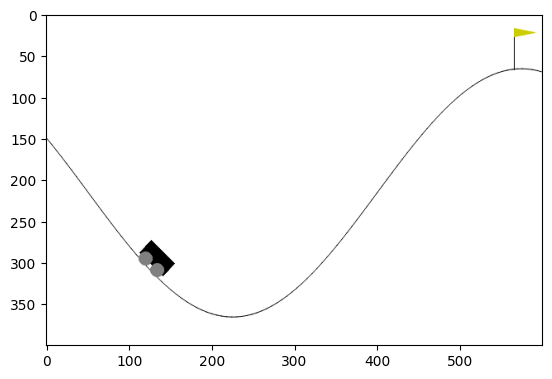

Q-value of the current state left=-49.94 nothing=-50.45 right=-50.80
Action: Left


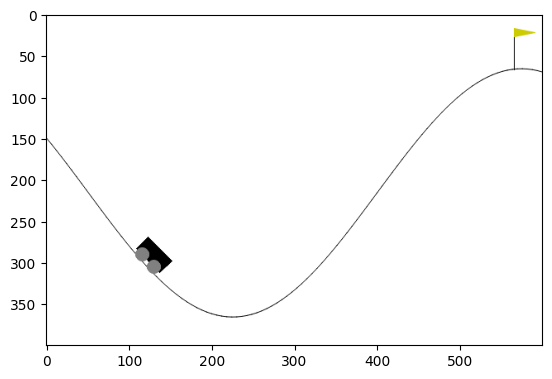

Q-value of the current state left=-49.47 nothing=-49.88 right=-50.13
Action: Left


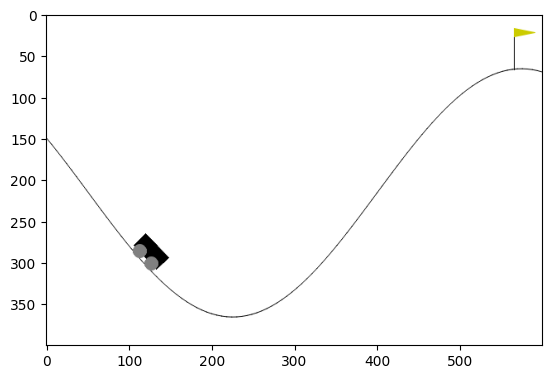

Q-value of the current state left=-49.03 nothing=-49.32 right=-49.48
Action: Left


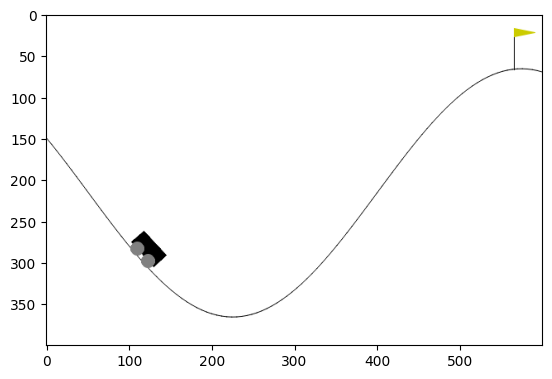

Q-value of the current state left=-48.63 nothing=-48.81 right=-48.87
Action: Left


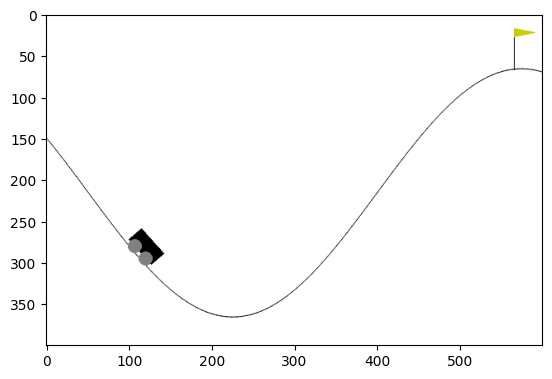

Q-value of the current state left=-48.33 nothing=-48.40 right=-48.35
Action: Left


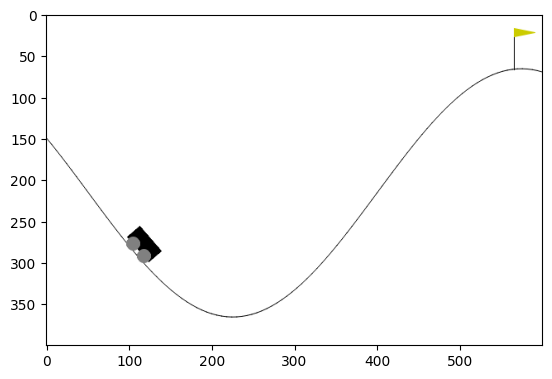

Q-value of the current state left=-47.91 nothing=-47.82 right=-47.62
Action: Right


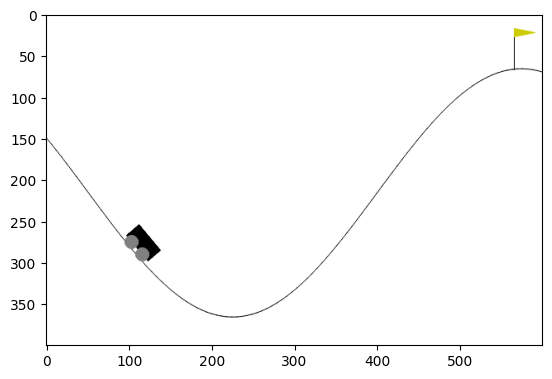

Q-value of the current state left=-47.68 nothing=-47.12 right=-46.46
Action: Right


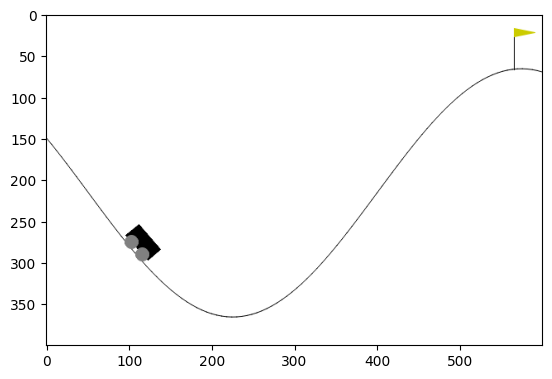

Q-value of the current state left=-48.34 nothing=-47.45 right=-46.48
Action: Right


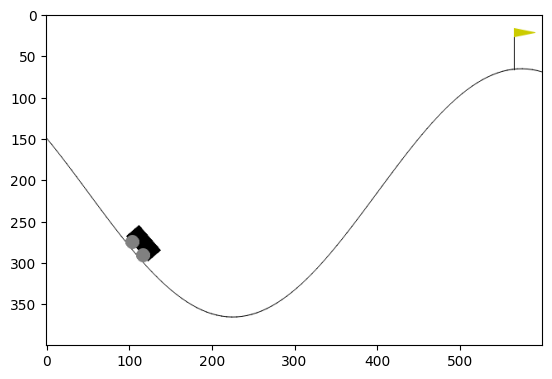

Q-value of the current state left=-49.06 nothing=-47.91 right=-46.71
Action: Right


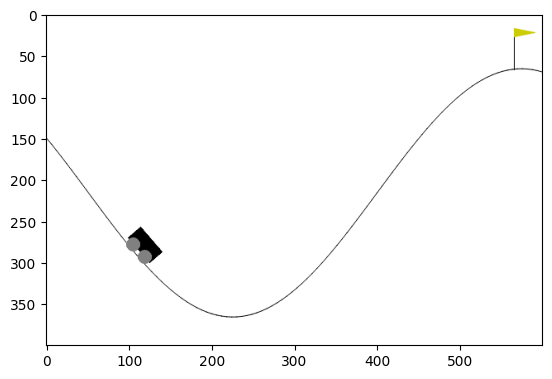

Q-value of the current state left=-48.67 nothing=-47.30 right=-45.89
Action: Right


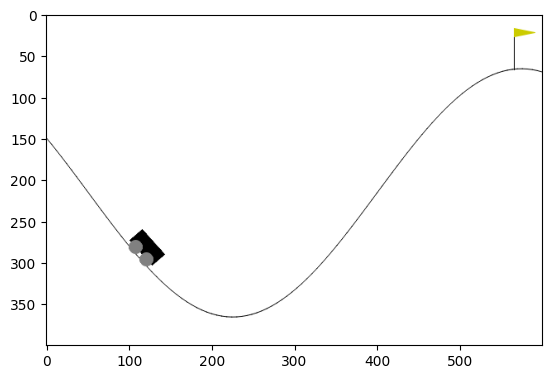

Q-value of the current state left=-47.65 nothing=-45.99 right=-44.31
Action: Right


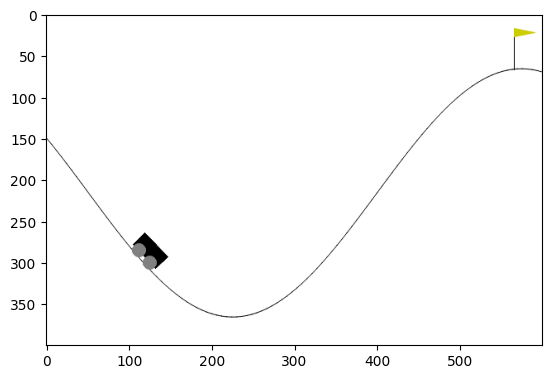

Q-value of the current state left=-47.02 nothing=-45.43 right=-43.87
Action: Right


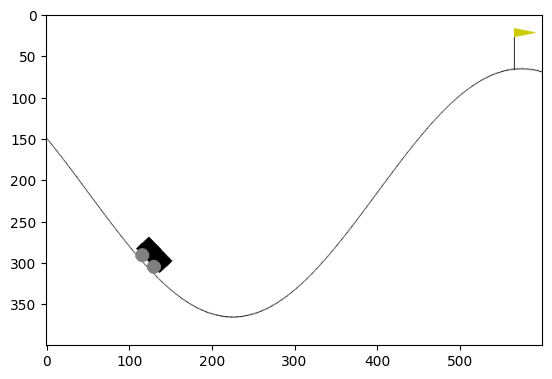

Q-value of the current state left=-46.94 nothing=-45.33 right=-43.77
Action: Right


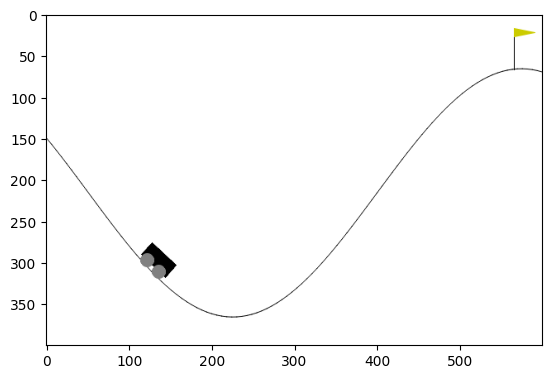

Q-value of the current state left=-45.68 nothing=-44.27 right=-42.99
Action: Right


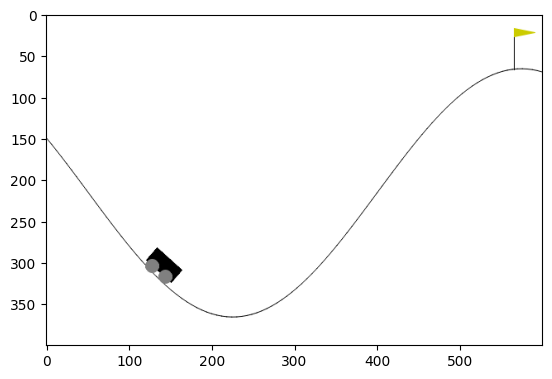

Q-value of the current state left=-44.24 nothing=-43.03 right=-41.98
Action: Right


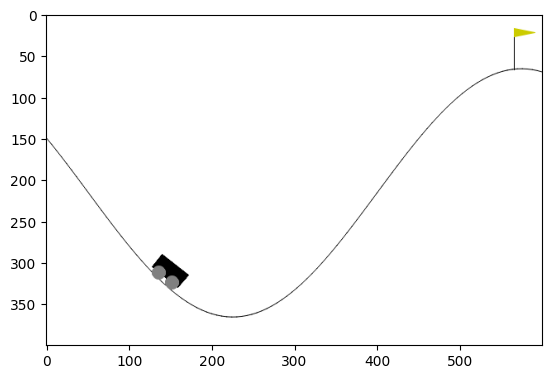

Q-value of the current state left=-43.62 nothing=-42.41 right=-41.27
Action: Right


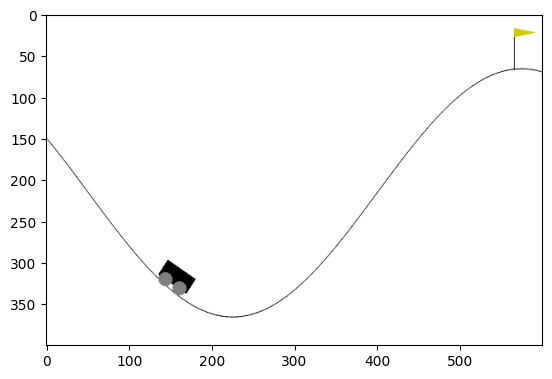

Q-value of the current state left=-43.32 nothing=-42.09 right=-40.85
Action: Right


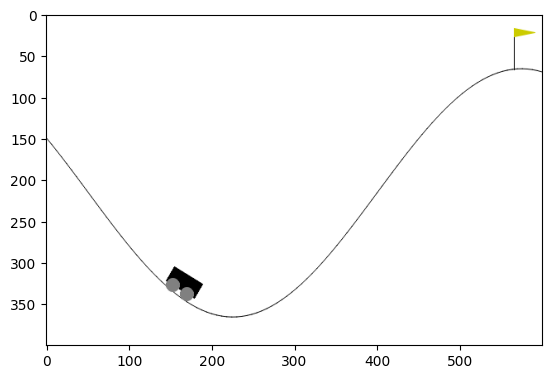

Q-value of the current state left=-43.20 nothing=-41.95 right=-40.61
Action: Right


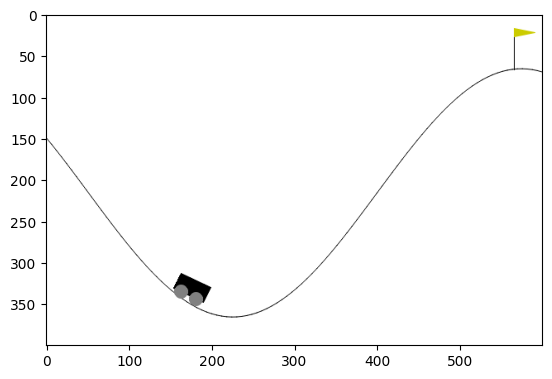

Q-value of the current state left=-43.64 nothing=-42.30 right=-40.88
Action: Right


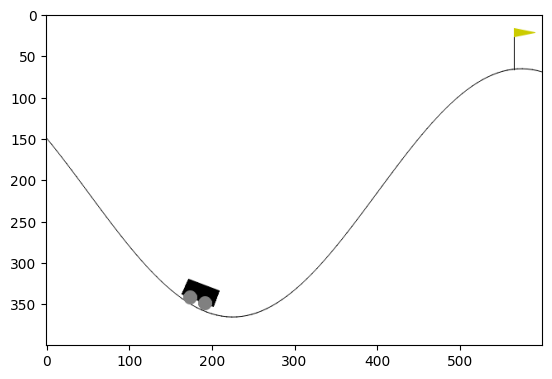

Q-value of the current state left=-42.46 nothing=-40.97 right=-39.54
Action: Right


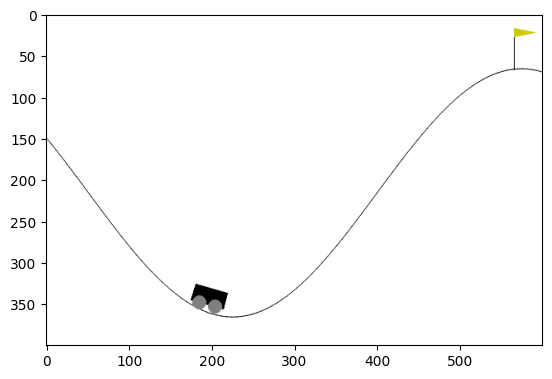

Q-value of the current state left=-41.94 nothing=-40.27 right=-38.81
Action: Right


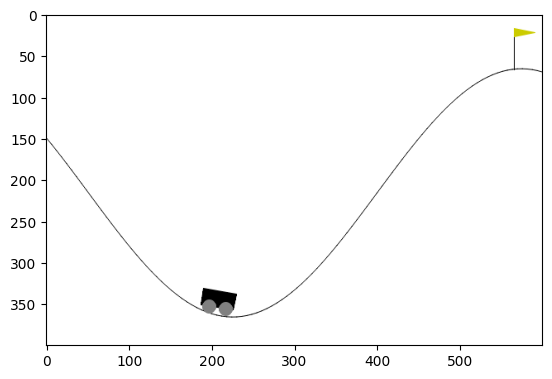

Q-value of the current state left=-42.05 nothing=-40.22 right=-38.74
Action: Right


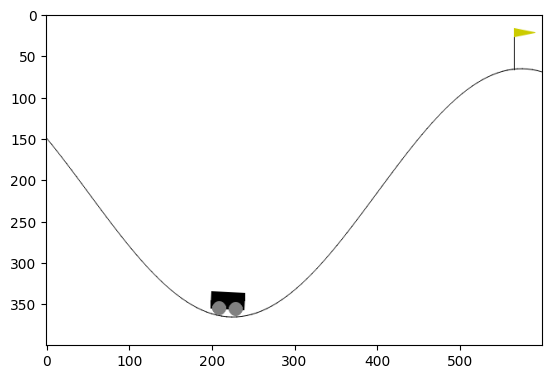

Q-value of the current state left=-43.59 nothing=-41.38 right=-39.75
Action: Right


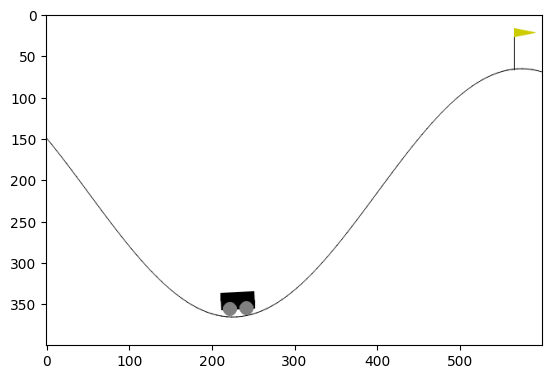

Q-value of the current state left=-44.53 nothing=-41.96 right=-40.20
Action: Right


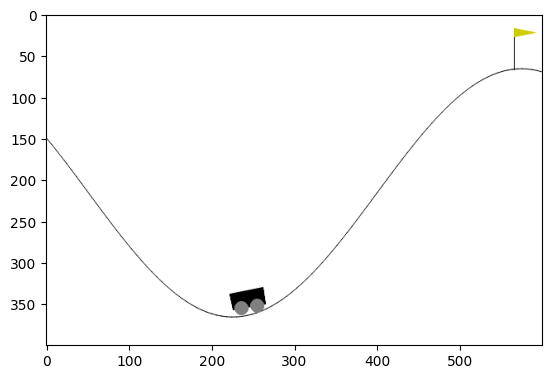

Q-value of the current state left=-47.70 nothing=-44.54 right=-42.37
Action: Right


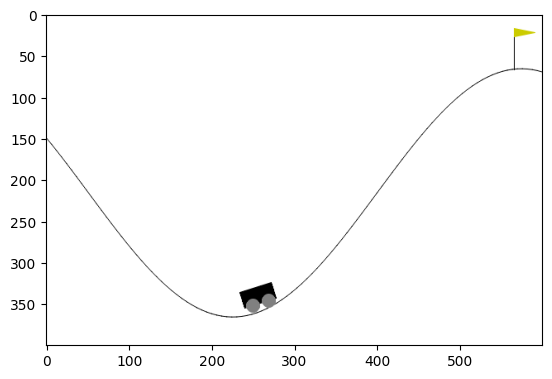

Q-value of the current state left=-48.13 nothing=-44.51 right=-42.02
Action: Right


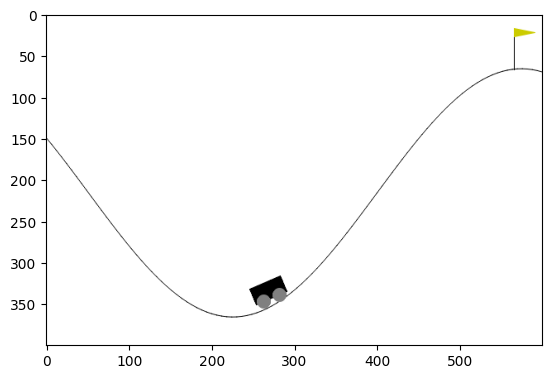

Q-value of the current state left=-47.93 nothing=-44.03 right=-41.62
Action: Right


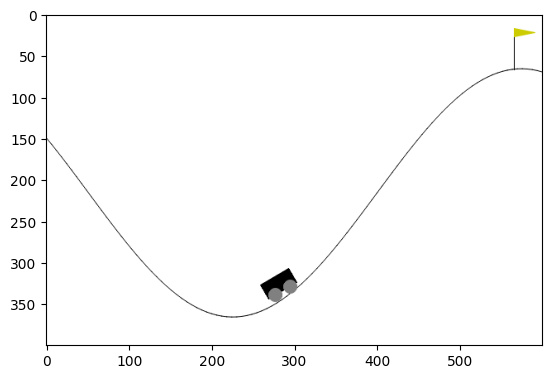

Q-value of the current state left=-47.17 nothing=-43.08 right=-40.58
Action: Right


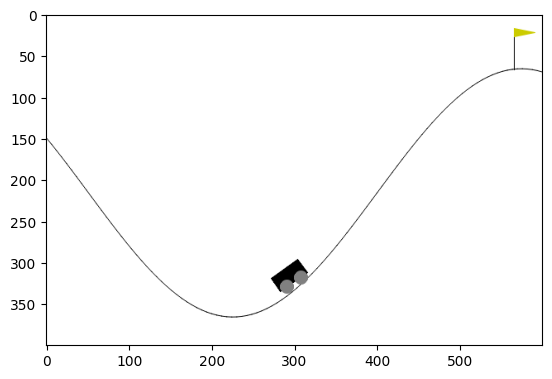

Q-value of the current state left=-45.08 nothing=-40.92 right=-38.29
Action: Right


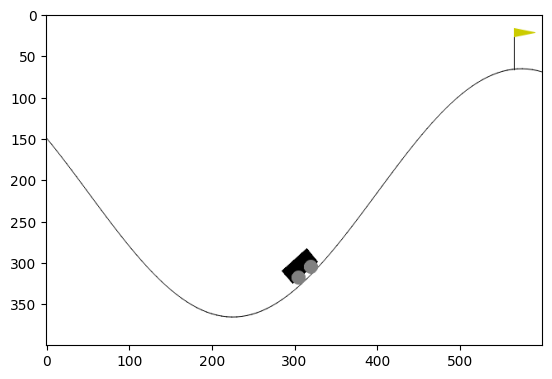

Q-value of the current state left=-44.51 nothing=-40.28 right=-37.57
Action: Right


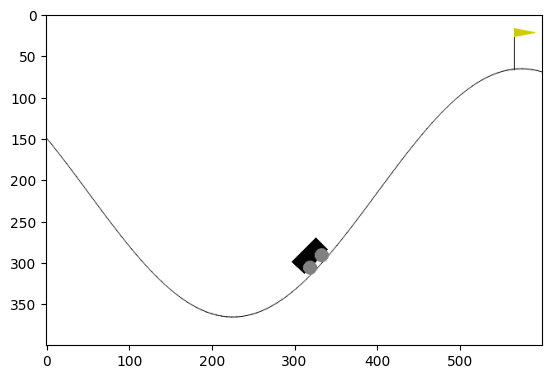

Q-value of the current state left=-44.58 nothing=-40.28 right=-37.51
Action: Right


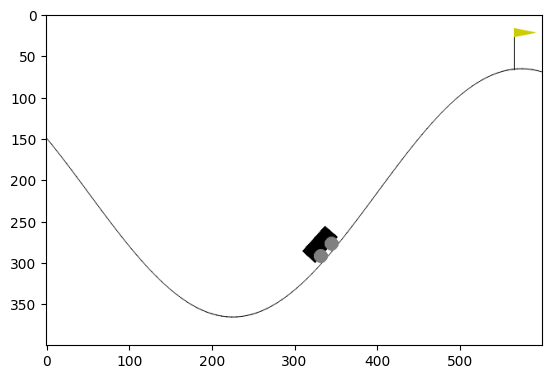

Q-value of the current state left=-43.46 nothing=-39.22 right=-36.48
Action: Right


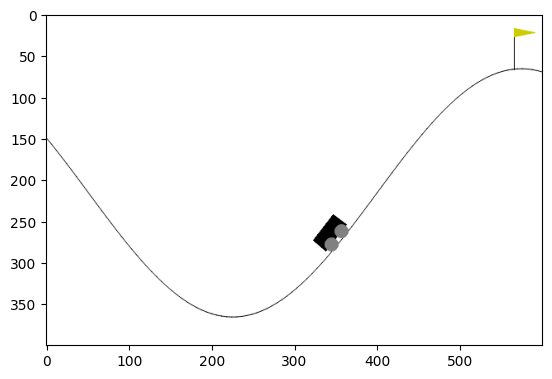

Q-value of the current state left=-42.44 nothing=-38.29 right=-35.60
Action: Right


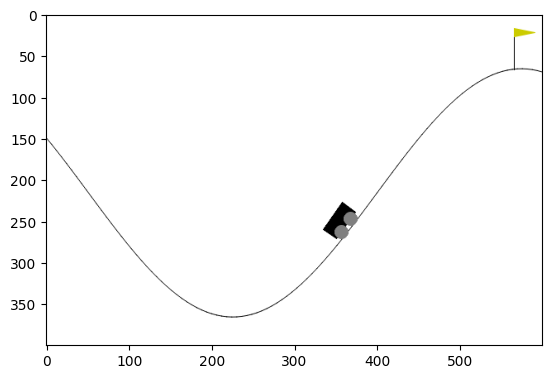

Q-value of the current state left=-42.05 nothing=-37.96 right=-35.33
Action: Right


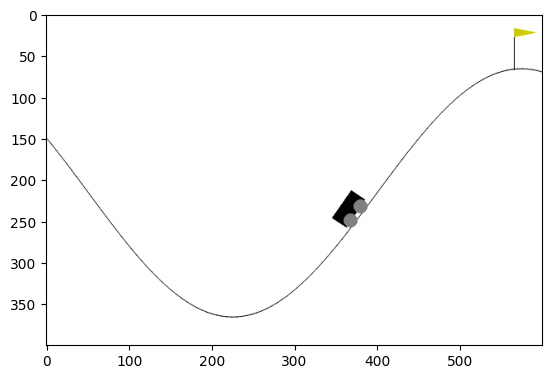

Q-value of the current state left=-40.54 nothing=-36.60 right=-34.06
Action: Right


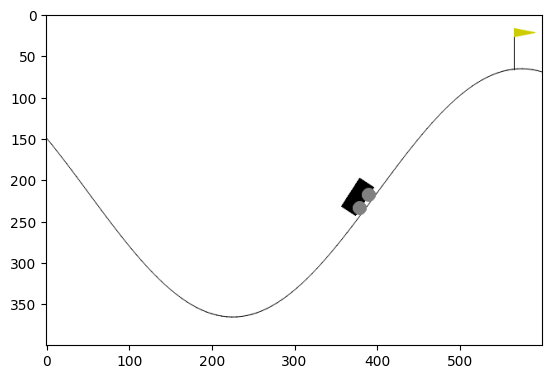

Q-value of the current state left=-39.61 nothing=-35.79 right=-33.33
Action: Right


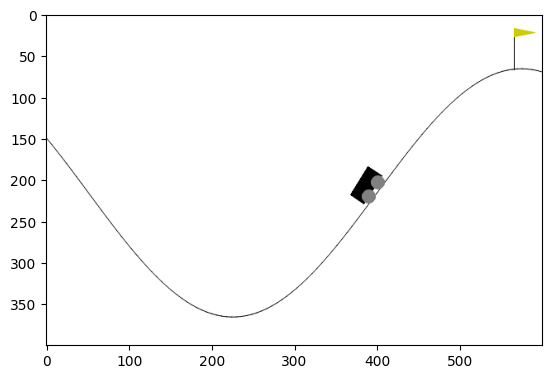

Q-value of the current state left=-39.52 nothing=-35.81 right=-33.43
Action: Right


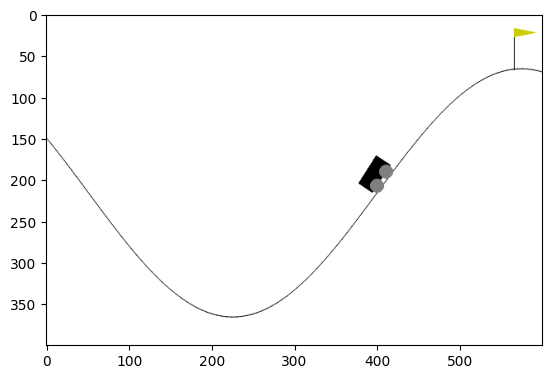

Q-value of the current state left=-39.93 nothing=-36.30 right=-34.01
Action: Right


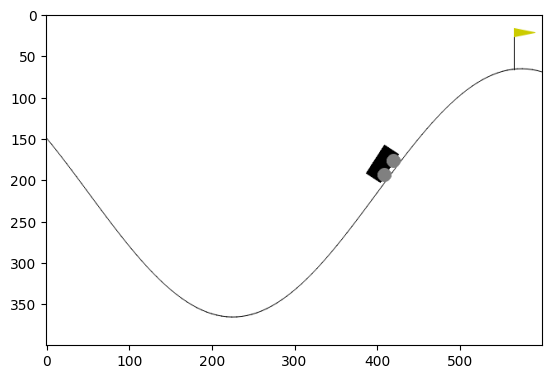

Q-value of the current state left=-39.19 nothing=-35.79 right=-33.68
Action: Right


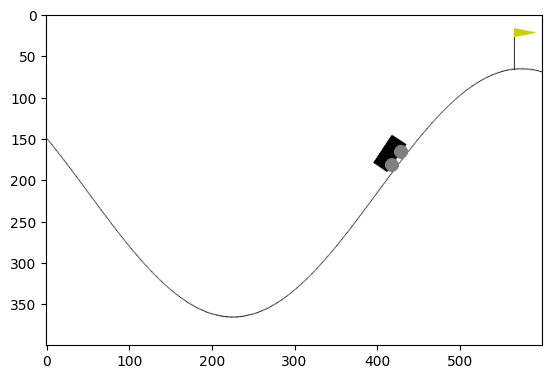

Q-value of the current state left=-37.13 nothing=-34.10 right=-32.28
Action: Right


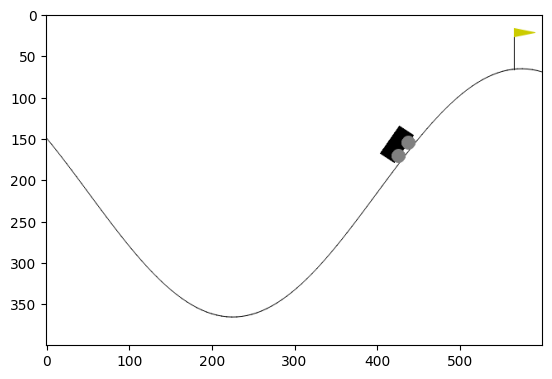

Q-value of the current state left=-35.29 nothing=-32.62 right=-31.09
Action: Right


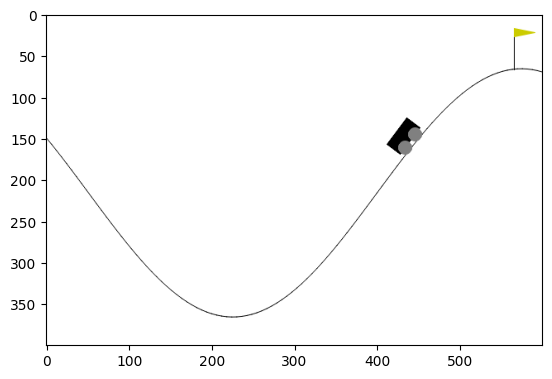

Q-value of the current state left=-33.65 nothing=-31.33 right=-30.07
Action: Right


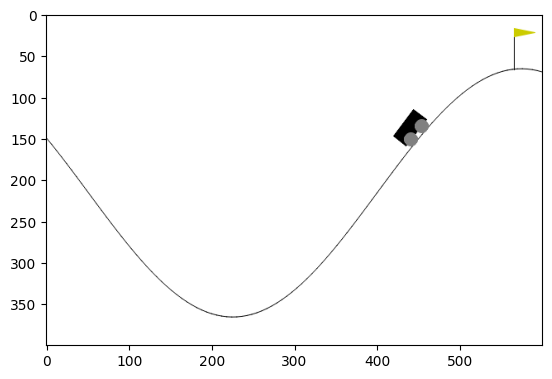

Q-value of the current state left=-31.65 nothing=-29.70 right=-28.74
Action: Right


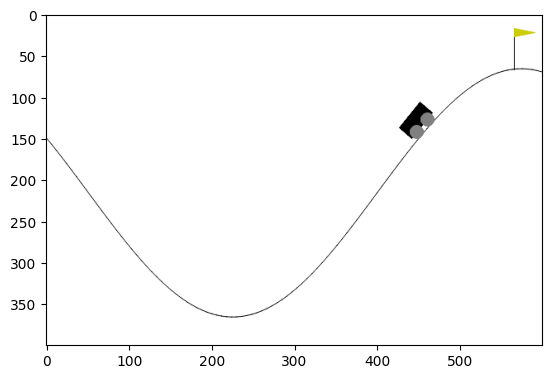

Q-value of the current state left=-30.55 nothing=-28.86 right=-28.07
Action: Right


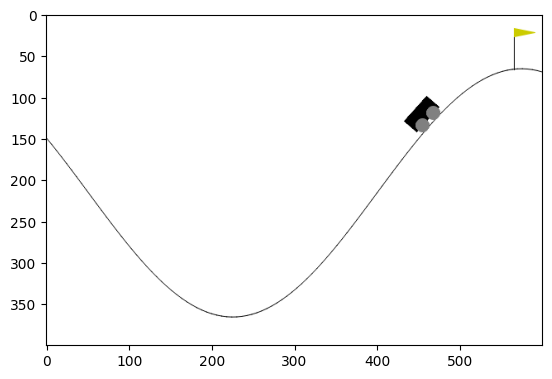

Q-value of the current state left=-30.20 nothing=-28.67 right=-27.93
Action: Right


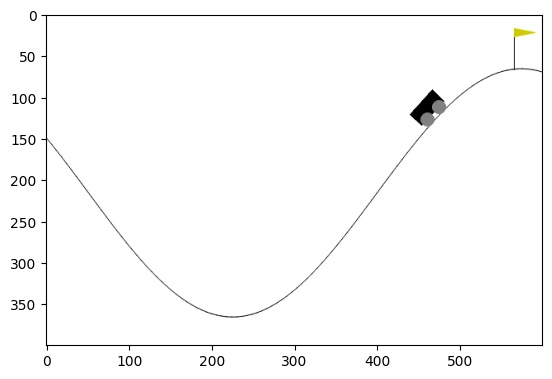

Q-value of the current state left=-29.84 nothing=-28.46 right=-27.77
Action: Right


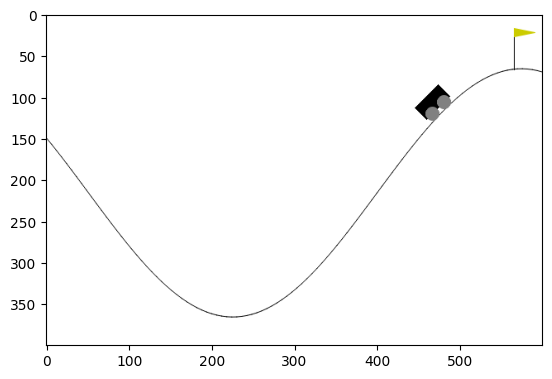

Q-value of the current state left=-29.45 nothing=-28.20 right=-27.56
Action: Right


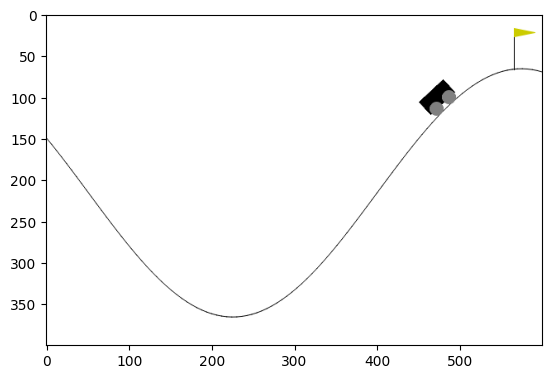

Q-value of the current state left=-28.99 nothing=-27.87 right=-27.27
Action: Right


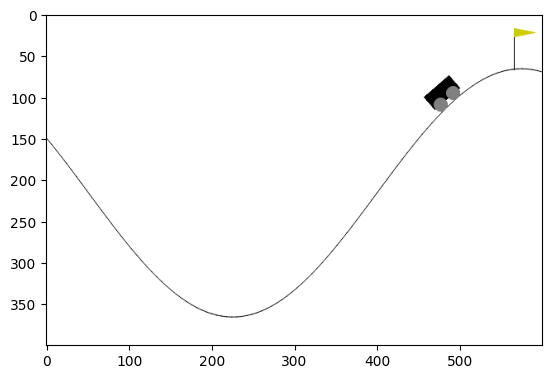

Q-value of the current state left=-28.47 nothing=-27.47 right=-26.91
Action: Right


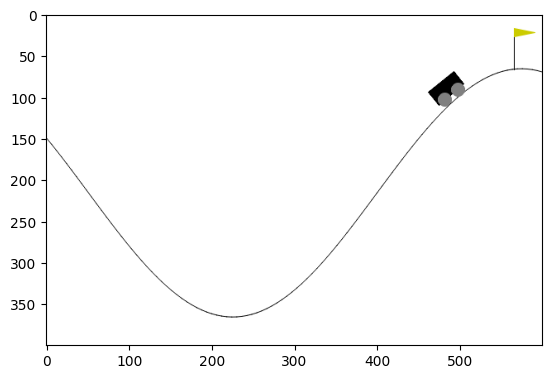

Q-value of the current state left=-27.87 nothing=-26.98 right=-26.44
Action: Right


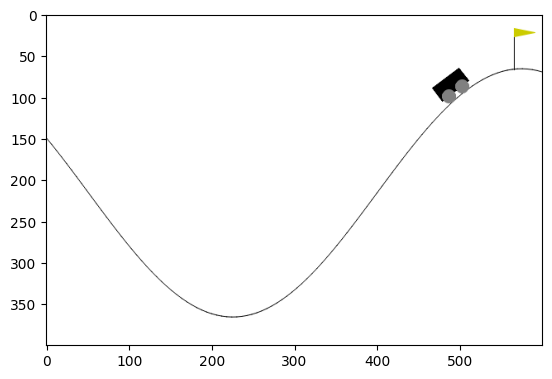

Q-value of the current state left=-27.15 nothing=-26.36 right=-25.84
Action: Right


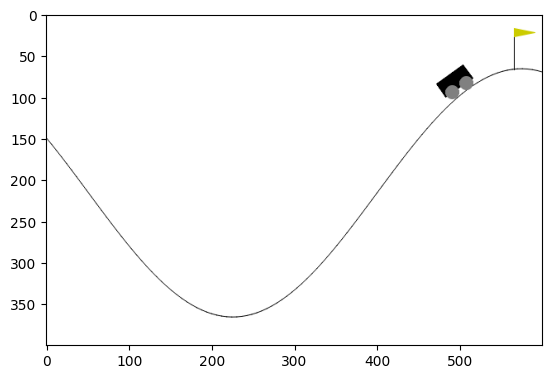

Q-value of the current state left=-25.80 nothing=-25.13 right=-24.58
Action: Right


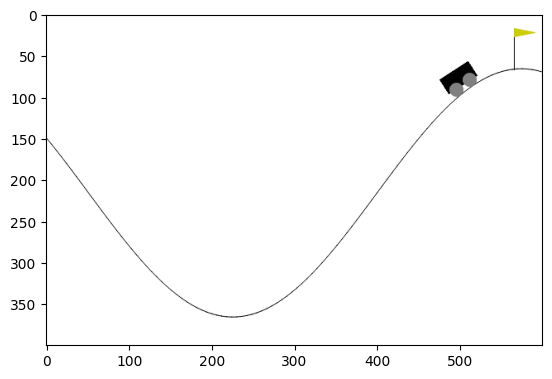

Q-value of the current state left=-24.08 nothing=-23.52 right=-22.94
Action: Right


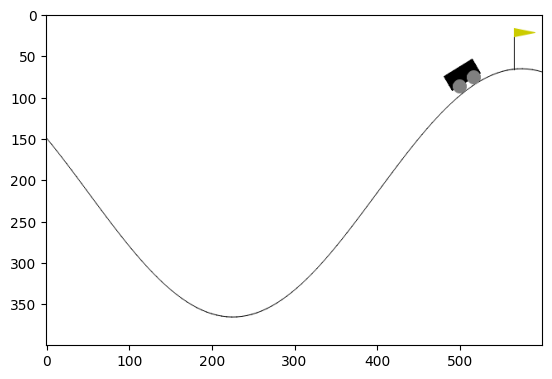

Q-value of the current state left=-22.35 nothing=-21.90 right=-21.28
Action: Right


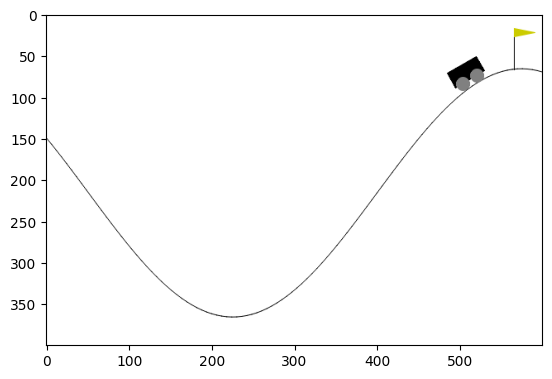

Q-value of the current state left=-20.60 nothing=-20.24 right=-19.57
Action: Right


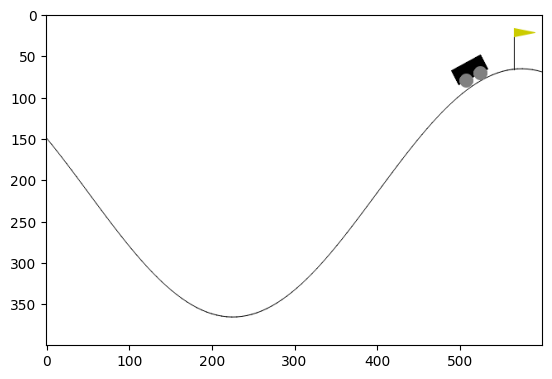

Q-value of the current state left=-18.81 nothing=-18.55 right=-17.83
Action: Right


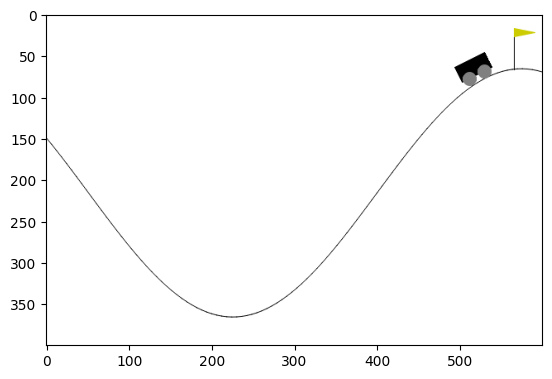

Q-value of the current state left=-17.30 nothing=-17.10 right=-16.36
Action: Right


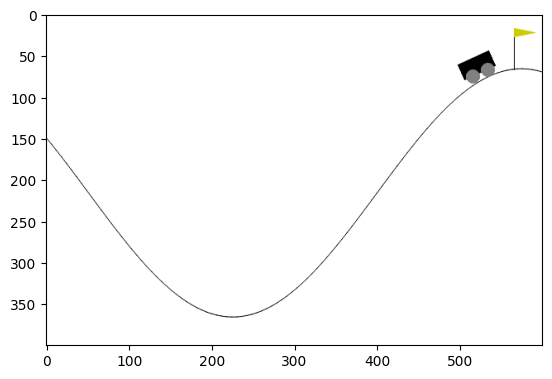

Q-value of the current state left=-15.70 nothing=-15.56 right=-14.80
Action: Right


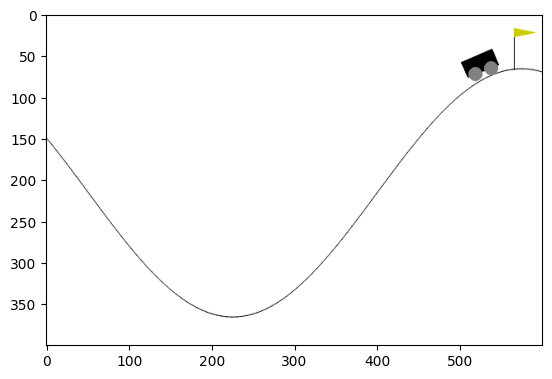

Q-value of the current state left=-14.00 nothing=-13.91 right=-13.11
Action: Right


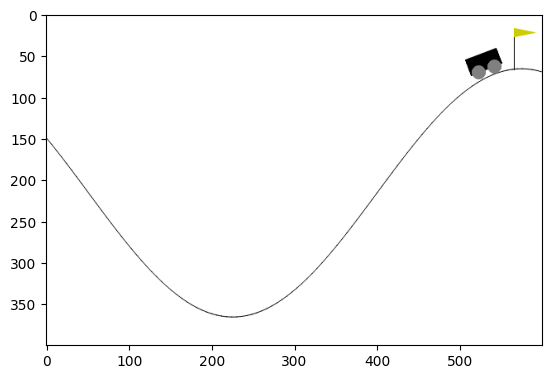

Q-value of the current state left=-12.18 nothing=-12.13 right=-11.29
Action: Right


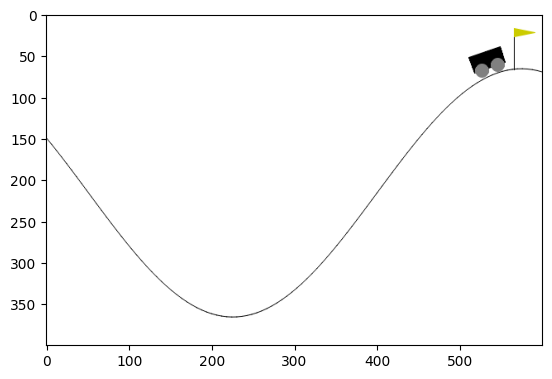

Q-value of the current state left=-10.52 nothing=-10.49 right=-9.60
Action: Right


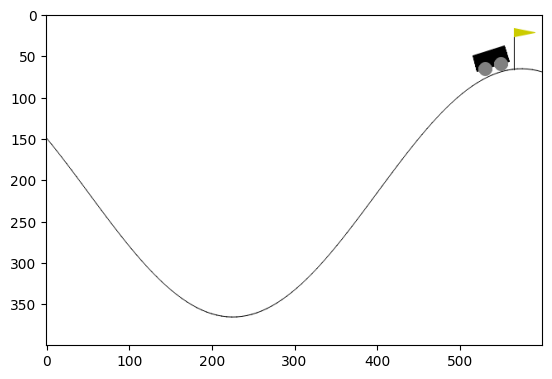

Q-value of the current state left=-9.04 nothing=-8.99 right=-8.06
Action: Right


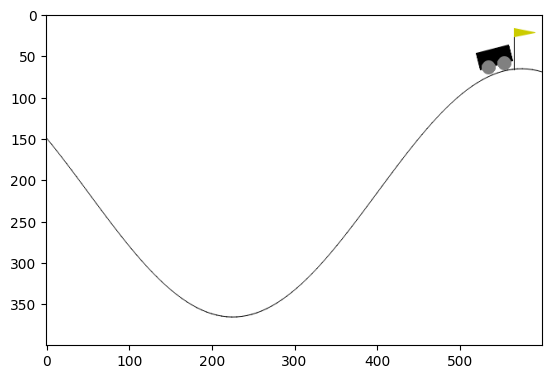

Q-value of the current state left=-7.57 nothing=-7.51 right=-6.54
Action: Right


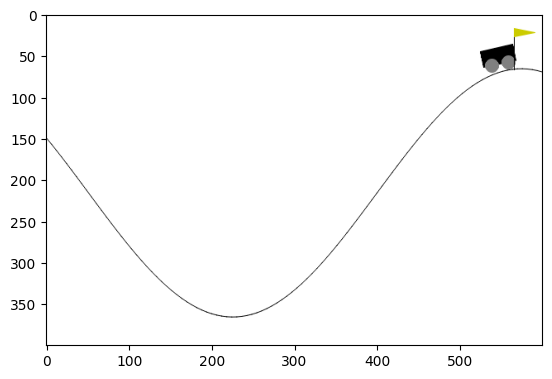

Q-value of the current state left=-6.42 nothing=-6.35 right=-5.36
Action: Right


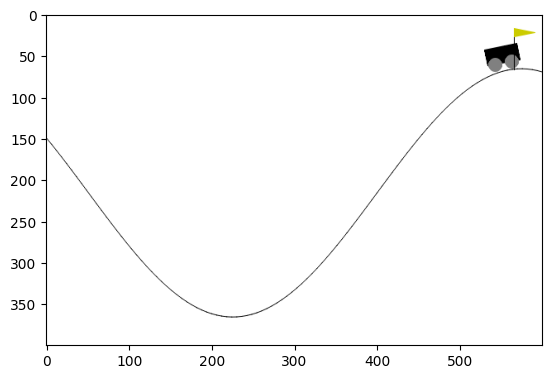

Q-value of the current state left=-5.12 nothing=-5.05 right=-4.03
Action: Right


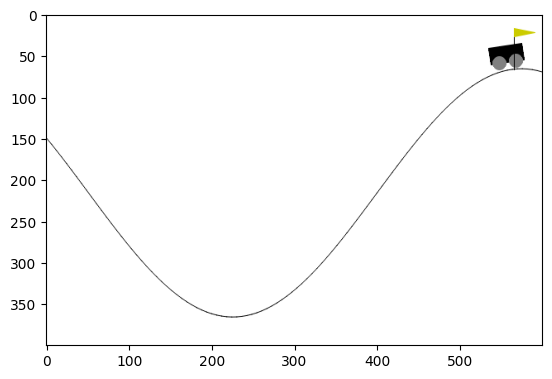

Q-value of the current state left=-4.51 nothing=-4.43 right=-3.40
Action: Right


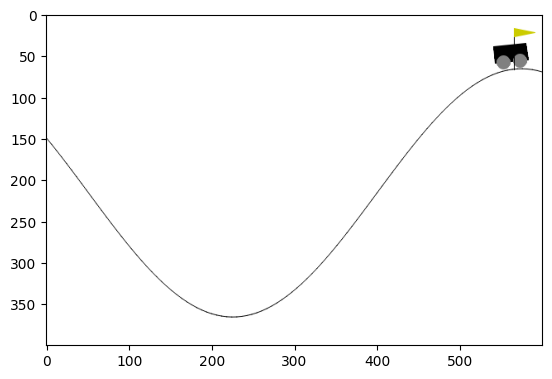

Q-value of the current state left=-4.51 nothing=-4.43 right=-3.40
Action: Right


In [80]:
episode_rewards = []
done = False
i = 0

while not done:
    i += 1

    # Display current state
    plt.imshow(env.render())
    plt.show()

    # Retrieve q-value
    q_values = get_q_values(dqn_model, obs)

    # Take greedy-action
    action, _ = dqn_model.predict(obs, deterministic=True)

    print(f"Q-value of the current state left={q_values[0]:.2f} nothing={q_values[1]:.2f} right={q_values[2]:.2f}")
    print(f"Action: {action_str[action]}")

    obs, reward, terminated, truncated, info = env.step(action)

    done = terminated or truncated

    episode_rewards.append(reward)


### Exercise (3 minutes): compare estimated initial q-value with actual discounted return

Compute the discounted return (sum of discounted reward) of the episode and compare it to the initial estimated q-value.

Note: You will need to use the discount factor `dqn_model.gamma`

In [85]:
sum_discounted_rewards = 0

### YOUR CODE HERE
# Compute the sum of discounted reward for the last episode
# using `episode_rewards` list and `dqn_model.gamma` discount factor
for t, reward in enumerate(reversed(episode_rewards)):
    sum_discounted_rewards += (dqn_model.gamma ** t) * reward

### END OF YOUR CODE

print(f"Sum discounted rewards: {sum_discounted_rewards:.2f}, initial q-value {initial_q_value:.2f}")

Sum discounted rewards: -61.51, initial q-value -61.15


## Exercise (30 minutes): Double DQN

In DQN, the same network is responsible for selecting and estimating the best next action (in the TD-target) and that may lead to over-estimation (the action which q-value is over-estimated will be chosen more often and this slow down training).

To reduce over-estimation, double q-learning (and then double DQN) was proposed. It decouples the action selection from the value estimation.

Concretely, in DQN, the target q-value is defined as:

$$Y^{DQN}_{t} = r_{t+1} + \gamma{Q}\left(s_{t+1}, \arg\max_{a}Q\left(s_{t+1}, a; \mathbb{\theta}_{target}\right); \mathbb{\theta}_{target}\right)$$

where the target network `q_net_target` with parameters $\mathbb{\theta}_{target}$ is used for both action selection and estimation, and can therefore be rewritten:

$$Y^{DQN}_{t} = r_{t+1} + \gamma \max_{a}{Q}\left(s_{t+1}, a; \mathbb{\theta}_{target}\right)$$

Double DQN uses the online network `q_net` with parameters $\mathbb{\theta}_{online}$ to select the action and the target network `q_net_target` to estimate the associated q-values:

$$Y^{DoubleDQN}_{t} = r_{t+1} + \gamma{Q}\left(s_{t+1}, \arg\max_{a}Q\left(s_{t+1}, a; \mathbb{\theta}_{online}\right); \mathbb{\theta}_{target}\right)$$


The goal in this exercise is for you to write the update method for `DoubleDQN`.

You will need to:

1. Sample replay buffer data using `self.replay_buffer.sample(batch_size)`

2. Compute the Double DQN target q-value using the next observations `replay_data.next_observation`, the online network `self.q_net`, the target network `self.q_net_target`, the rewards `replay_data.rewards` and the termination signals `replay_data.dones`. Be careful with the shape of each object ;)

3. Compute the current q-value estimates using the online network `self.q_net`, the current observations `replay_data.observations` and the buffer actions `replay_data.actions`

4. Compute the loss to train the q-network using L2 or Huber loss (`F.smooth_l1_loss`)


Link: https://paperswithcode.com/method/double-q-learning

Paper: https://arxiv.org/abs/1509.06461



In [180]:
from torch.nn import functional as F

class DoubleDQN(DQN):
    def train(self, gradient_steps: int, batch_size: int = 100) -> None:
        # Switch to train mode (this affects batch norm / dropout)
        self.policy.set_training_mode(True)
        # Update learning rate according to schedule
        self._update_learning_rate(self.policy.optimizer)

        losses = []
        for _ in range(gradient_steps):
            ### YOUR CODE HERE
            # Sample replay buffer
            replay_data = self.replay_buffer.sample(batch_size)

            # Do not backpropagate gradient to the target network
            with th.no_grad():
                # Compute the next Q-values using the target network
                next_q_values = self.q_net_target(replay_data.next_observations)
                # Decouple action selection from value estimation
                # Compute q-values for the next observation using the online q net
                next_q_values_online = self.q_net(replay_data.next_observations)
                # Select action with online network
                next_actions_online = th.argmax(next_q_values_online, dim=1)
                # Estimate the q-values for the selected actions using target q network
                next_q_values = th.gather(next_q_values, dim=1, index=next_actions_online.unsqueeze(-1))

                # 1-step TD target
                target_q_values = replay_data.rewards + (1 - replay_data.dones) * self.gamma * next_q_values

            # Get current Q-values estimates
            current_q_values = self.q_net(replay_data.observations)

            # Retrieve the q-values for the actions from the replay buffer
            current_q_values = th.gather(current_q_values, dim=1, index=replay_data.actions.long())

            # Check the shape
            assert current_q_values.shape == target_q_values.shape

            # Compute loss (L2 or Huber loss)
            loss = F.smooth_l1_loss(current_q_values, target_q_values)

            ### END OF YOUR CODE

            losses.append(loss.item())

            # Optimize the q-network
            self.policy.optimizer.zero_grad()
            loss.backward()
            # Clip gradient norm
            th.nn.utils.clip_grad_norm_(self.policy.parameters(), self.max_grad_norm)
            self.policy.optimizer.step()

        # Increase update counter
        self._n_updates += gradient_steps

        self.logger.record("train/n_updates", self._n_updates, exclude="tensorboard")
        self.logger.record("train/loss", np.mean(losses))

## Monitoring Evolution of the Estimated q-value


Here we create a SB3 callback to over-estimate initial q-values and then monitor their evolution over time.

In [164]:
from torch.nn import functional as F

from stable_baselines3.common.callbacks import BaseCallback


class MonitorQValueCallback(BaseCallback):
    """
    Callback to monitor the evolution of the q-value
    for the initial state.
    It allows to artificially over-estimate a q-value for initial states.

    """
    def __init__(self, sample_interval: int = 2500):
        super().__init__()
        self.timesteps = []
        self.max_q_values = []
        self.sample_interval = sample_interval
        n_samples = 512
        env = gym.make("MountainCar-v0")
        # Sample initial states that will be used to monitor the estimated q-value
        self.start_obs = np.array([env.reset() for _ in range(n_samples)])
        #self.start_obs = np.array([env.reset() for _ in range(n_samples)], dtype=np.float32)


    def _on_training_start(self) -> None:
        # Create overestimation
        numpy_arrays = [item[0] for item in self.start_obs]
        combined_array = np.stack(numpy_arrays)
        obs = th.tensor(combined_array, device=self.model.device).float()
        # Over-estimate going left q-value for the initial states
        target_q_values = th.ones((len(obs), 1), device=self.model.device).float() * 100

        for _ in range(100):
            # Get current Q-values estimates
            current_q_values = self.model.q_net(obs)

            # Over-estimate going left
            current_q_values = th.gather(current_q_values, dim=1, index=th.zeros((len(obs), 1), device=self.model.device).long())

            loss = F.mse_loss(current_q_values, target_q_values)

            # Optimize the policy
            self.model.policy.optimizer.zero_grad()
            loss.backward()
            self.model.policy.optimizer.step()

    def _on_step(self) -> bool:
        # Sample q-values
        if self.n_calls % self.sample_interval == 0:
            # Monitor estimated q-values using current model
            numpy_arrays = [item[0] for item in self.start_obs]
            combined_array = np.stack(numpy_arrays)
            obs = th.tensor(combined_array, device=self.model.device).float()
            with th.no_grad():
                q_values = self.model.q_net(obs).cpu().numpy()

            self.logger.record("train/max_q_value", float(q_values.max()))
            self.timesteps.append(self.num_timesteps)
            self.max_q_values.append(q_values.max())
        return True

## Evolution of the q-value with initial over-estimation

### DQN

In [165]:
dqn_model = DQN(
    "MlpPolicy",
    "MountainCar-v0",
    verbose=1,
    train_freq=16,
    gradient_steps=8,
    gamma=0.99,
    exploration_fraction=0.2,
    exploration_final_eps=0.07,
    target_update_interval=5000,
    learning_starts=1000,
    buffer_size=25000,
    batch_size=128,
    learning_rate=4e-3,
    policy_kwargs=dict(net_arch=[256, 256]),
    tensorboard_log=tensorboard_log,
    seed=102,
)

Using cpu device
Creating environment from the given name 'MountainCar-v0'
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


Define the callback

In [166]:
monitor_dqn_value_cb = MonitorQValueCallback()

<ipython-input-164-25378a5b0bda>:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.start_obs = np.array([env.reset() for _ in range(n_samples)])


In [167]:
dqn_model.learn(total_timesteps=int(4e4), callback=monitor_dqn_value_cb)

Logging to data/tb/DQN_33
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | -200     |
|    exploration_rate | 0.907    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 1124     |
|    time_elapsed     | 0        |
|    total_timesteps  | 800      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | -200     |
|    exploration_rate | 0.814    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 705      |
|    time_elapsed     | 2        |
|    total_timesteps  | 1600     |
| train/              |          |
|    learning_rate    | 0.004    |
|    loss             | 0.00043  |
|    n_updates        | 296      |
----------------------------------
----------------------------------
| rollout/            |      

### Double DQN

In [181]:
double_q = DoubleDQN("MlpPolicy",
            "MountainCar-v0",
            verbose=1,
            train_freq=16,
            gradient_steps=8,
            gamma=0.99,
            exploration_fraction=0.2,
            exploration_final_eps=0.07,
            target_update_interval=5000,
            learning_starts=1000,
            buffer_size=25000,
            batch_size=128,
            learning_rate=4e-3,
            policy_kwargs=dict(net_arch=[256, 256]),
            tensorboard_log=tensorboard_log,
            seed=102)

Using cpu device
Creating environment from the given name 'MountainCar-v0'
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [182]:
monitor_double_q_value_cb = MonitorQValueCallback()

<ipython-input-164-25378a5b0bda>:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.start_obs = np.array([env.reset() for _ in range(n_samples)])


In [183]:
double_q.learn(int(4e4), log_interval=10, callback=monitor_double_q_value_cb)

Logging to data/tb/DQN_37
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | -200     |
|    exploration_rate | 0.767    |
| time/               |          |
|    episodes         | 10       |
|    fps              | 580      |
|    time_elapsed     | 3        |
|    total_timesteps  | 2000     |
| train/              |          |
|    learning_rate    | 0.004    |
|    loss             | 0.107    |
|    n_updates        | 496      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | -200     |
|    exploration_rate | 0.535    |
| time/               |          |
|    episodes         | 20       |
|    fps              | 398      |
|    time_elapsed     | 10       |
|    total_timesteps  | 4000     |
| train/              |          |
|    learning_rate    | 0.004    |
|    loss             | 0.148

### Evolution of the max q-value for start states over time

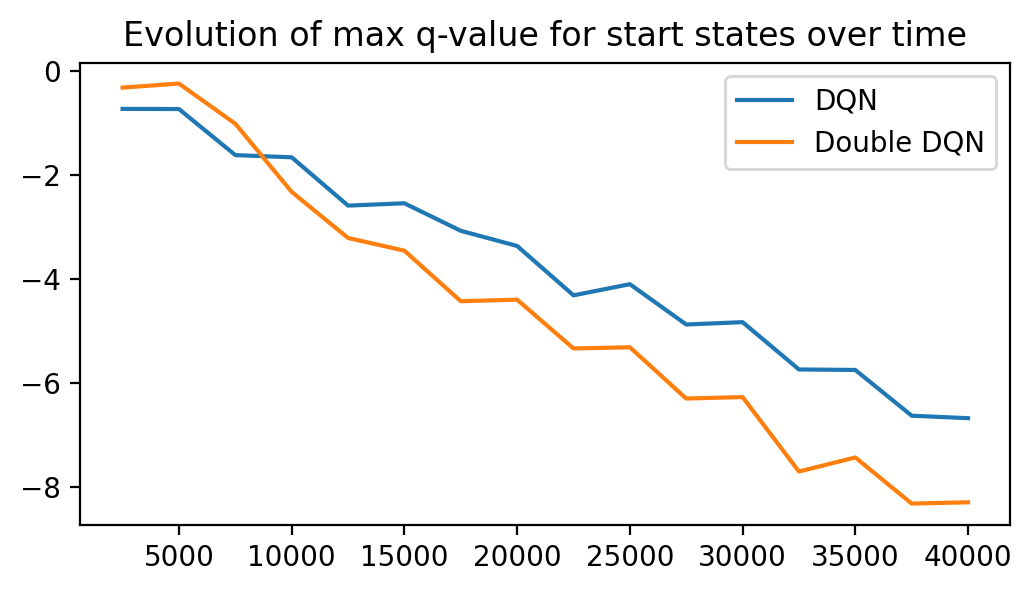

In [184]:
plt.figure(figsize=(6, 3), dpi=200)
plt.title("Evolution of max q-value for start states over time")
plt.plot(monitor_dqn_value_cb.timesteps, monitor_dqn_value_cb.max_q_values, label="DQN")
plt.plot(monitor_double_q_value_cb.timesteps, monitor_double_q_value_cb.max_q_values, label="Double DQN")
plt.legend()